## Hexbin stats

Refs:  
- https://darribas.org/gds_course/content/bG/lab_G.html
- https://geographicdata.science/book/notebooks/00_toc.html
- https://geodacenter.github.io/documentation.html

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon
from pysal.lib import weights
from libpysal.weights import w_subset
import h3

from palettable.tableau import Tableau_10
import folium
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

from functools import partial
from pathlib import Path

# from matplotlib import colors
import matplotlib.pyplot as plt


## Data loading

In [ ]:
fname = Path.home() / 'pro/data/maris/maris-seawater-lamer-2023-07-25.csv'
df = pd.read_csv(fname); df.shape

(29419, 13)

In [ ]:
# Filtering out North Atlantic Ocean
#df = df[df['area_name'] != 'North Atlantic Ocean']
df['begperiod'] = pd.to_datetime(df['begperiod'])

In [ ]:
df.head()

,smp_id,lat,lon,area_name,area_id,depth,profile_id,begperiod,nusymbol,unit,activity,uncertainty,ref_id
0,10829,56.783333,-8.000000,North Atlantic Ocean,1912,40.0,NaN,1984-06-27,137Cs,Bq/m3,99.84,1.40,84
1,10045,57.000000,-20.000000,North Atlantic Ocean,1912,3.0,NaN,1981-03-15,137Cs,Bq/m3,5.74,0.66,84
2,5811,59.000000,-6.000000,North Atlantic Ocean,1912,79.0,NaN,1973-07-22,137Cs,Bq/m3,22.57,NaN,84
3,3324,58.590000,-3.791667,North Atlantic Ocean,1912,0.0,NaN,1967-11-08,137Cs,Bq/m3,359.64,NaN,84
4,3747,58.583333,-3.766667,North Atlantic Ocean,1912,0.0,NaN,1966-05-25,137Cs,Bq/m3,92.13,NaN,84


## H3 encoding

In [ ]:
# https://uber.github.io/h3-py/api_reference
# https://h3geo.org/docs/quickstart
def to_h3(row, resolution=1, lat_col='lat', lon_col='lon'): 
    return h3.latlng_to_cell(row[lat_col], row[lon_col], resolution)

In [ ]:
resolution = 3
df['h3_idx'] = df.apply(partial(to_h3, resolution=resolution), axis=1)

In [ ]:
df.head()

,smp_id,lat,lon,area_name,area_id,depth,profile_id,begperiod,nusymbol,unit,activity,uncertainty,ref_id,h3_idx
0,10829,56.783333,-8.000000,North Atlantic Ocean,1912,40.0,NaN,1984-06-27,137Cs,Bq/m3,99.84,1.40,84,83190afffffffff
1,10045,57.000000,-20.000000,North Atlantic Ocean,1912,3.0,NaN,1981-03-15,137Cs,Bq/m3,5.74,0.66,84,831981fffffffff
2,5811,59.000000,-6.000000,North Atlantic Ocean,1912,79.0,NaN,1973-07-22,137Cs,Bq/m3,22.57,NaN,84,831905fffffffff
3,3324,58.590000,-3.791667,North Atlantic Ocean,1912,0.0,NaN,1967-11-08,137Cs,Bq/m3,359.64,NaN,84,831928fffffffff
4,3747,58.583333,-3.766667,North Atlantic Ocean,1912,0.0,NaN,1966-05-25,137Cs,Bq/m3,92.13,NaN,84,831928fffffffff


In [ ]:
df = df.dropna(subset='activity')

In [ ]:
df['activity_log'] = np.log10(df.activity)

In [ ]:
aggregations = {
    'activity_log': [
        ('q1', lambda x: np.percentile(x, 1)),
        ('q2', lambda x: np.percentile(x, 2)),
        ('q3', lambda x: np.percentile(x, 3)),
        ('mean', 'mean'),
        ('min', 'min'),
        ('max', 'max'),
        ('std', lambda x: np.nanstd(x)),
        ('n', 'count')
    ]
}

df_hex = df.groupby('h3_idx').agg(aggregations); df_hex


activity_log                                          \
                          q1        q2        q3      mean       min   
h3_idx                                                                 
83060cfffffffff     0.800548  0.803136  0.805724  0.896058  0.797960   
83060dfffffffff     0.308863  0.310338  0.311812  0.381109  0.307389   
830628fffffffff    -0.040653 -0.032400 -0.024148  0.235645 -0.048905   
830629fffffffff    -0.022718 -0.020132 -0.009268  0.576696 -0.025304   
83062bfffffffff     0.605093  0.610302  0.615512  0.782245  0.599883   
...                      ...       ...       ...       ...       ...   
837c5efffffffff    -0.086186 -0.086186 -0.086186 -0.086186 -0.086186   
837c72fffffffff     0.204120  0.204120  0.204120  0.204120  0.204120   
837cb3fffffffff    -0.312221 -0.305020 -0.297818  0.040657 -0.319423   
8380d0fffffffff     0.371373  0.372607  0.373840  0.431815  0.370140   
8380d6fffffffff     0.370528  0.371761  0.372995  0.430969  0.369294   

                                         
                      max       std   n  
h3_idx                                   
83060cfffffffff  0.962843  0.070861   3  
83060dfffffffff  0.454830  0.073720   2  
830628fffffffff  0.392116  0.201541   3  
830629fffffffff  1.042979  0.318900  39  
83062bfffffffff  0.886491  0.129390   3  
...                   ...       ...  ..  
837c5efffffffff -0.086186  0.000000   1  
837c72fffffffff  0.204120  0.000000   1  
837cb3fffffffff  0.400737  0.360080   2  
8380d0fffffffff  0.493491  0.061675   2  
8380d6fffffffff  0.492645  0.061675   2  

[418 rows x 8 columns]

In [ ]:
# Reset the column names for the result DataFrame if needed
# result.columns = [f'{col[0]} ({col[1]})' for col in result.columns]
df_hex.columns = [f'{col[1]}' for col in df_hex.columns]
df_hex.reset_index(inplace=True)

In [ ]:
df_hex.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n
0,83060cfffffffff,0.800548,0.803136,0.805724,0.896058,0.797960,0.962843,0.070861,3
1,83060dfffffffff,0.308863,0.310338,0.311812,0.381109,0.307389,0.454830,0.073720,2
2,830628fffffffff,-0.040653,-0.032400,-0.024148,0.235645,-0.048905,0.392116,0.201541,3
3,830629fffffffff,-0.022718,-0.020132,-0.009268,0.576696,-0.025304,1.042979,0.318900,39
4,83062bfffffffff,0.605093,0.610302,0.615512,0.782245,0.599883,0.886491,0.129390,3


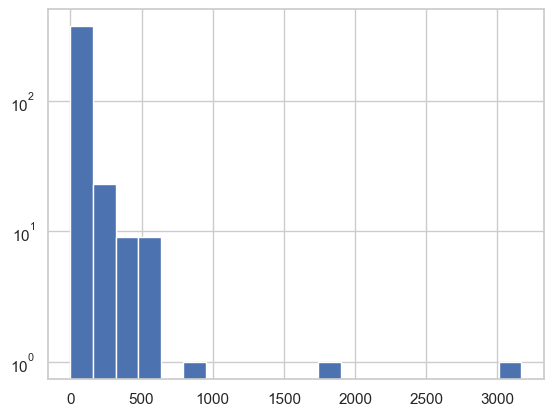

In [ ]:
plt.hist(df_hex.n, bins=20, alpha=1)
plt.yscale('log')

In [ ]:
def h3_to_polygon(h3_idx):
    h3_idx_geojson = h3.cell_to_boundary(h3_idx, geo_json=True)
    polygon = Polygon(h3_idx_geojson)
    return polygon

In [ ]:
df_hex['geometry'] = df_hex['h3_idx'].apply(h3_to_polygon)

In [ ]:
df_hex.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n,geometry
0,83060cfffffffff,0.800548,0.803136,0.805724,0.896058,0.797960,0.962843,0.070861,3,POLYGON ((-30.744537672047297 67.9796459443116...
1,83060dfffffffff,0.308863,0.310338,0.311812,0.381109,0.307389,0.454830,0.073720,2,POLYGON ((-31.11303184545239 66.88546232452366...
2,830628fffffffff,-0.040653,-0.032400,-0.024148,0.235645,-0.048905,0.392116,0.201541,3,POLYGON ((-26.14784938843164 67.65770874425667...
3,830629fffffffff,-0.022718,-0.020132,-0.009268,0.576696,-0.025304,1.042979,0.318900,39,"POLYGON ((-26.7051855950819 66.58962548375334,..."
4,83062bfffffffff,0.605093,0.610302,0.615512,0.782245,0.599883,0.886491,0.129390,3,POLYGON ((-28.654473927362766 67.2932253645357...


## To Geopandas

In [ ]:
gdf = gpd.GeoDataFrame(df_hex, geometry='geometry', crs="EPSG:4326")

In [ ]:
gdf.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n,geometry
0,83060cfffffffff,0.800548,0.803136,0.805724,0.896058,0.797960,0.962843,0.070861,3,"POLYGON ((-30.74454 67.97965, -32.32731 68.059..."
1,83060dfffffffff,0.308863,0.310338,0.311812,0.381109,0.307389,0.454830,0.073720,2,"POLYGON ((-31.11303 66.88546, -32.62750 66.957..."
2,830628fffffffff,-0.040653,-0.032400,-0.024148,0.235645,-0.048905,0.392116,0.201541,3,"POLYGON ((-26.14785 67.65771, -27.65321 67.778..."
3,830629fffffffff,-0.022718,-0.020132,-0.009268,0.576696,-0.025304,1.042979,0.318900,39,"POLYGON ((-26.70519 66.58963, -28.15044 66.701..."
4,83062bfffffffff,0.605093,0.610302,0.615512,0.782245,0.599883,0.886491,0.129390,3,"POLYGON ((-28.65447 67.29323, -30.16748 67.389..."


In [ ]:
# gdf = gdf.to_crs(3857)

In [ ]:
gdf.columns

Index(['h3_idx', 'q1', 'q2', 'q3', 'mean', 'min', 'max', 'std', 'n',
       'geometry'],
      dtype='object')

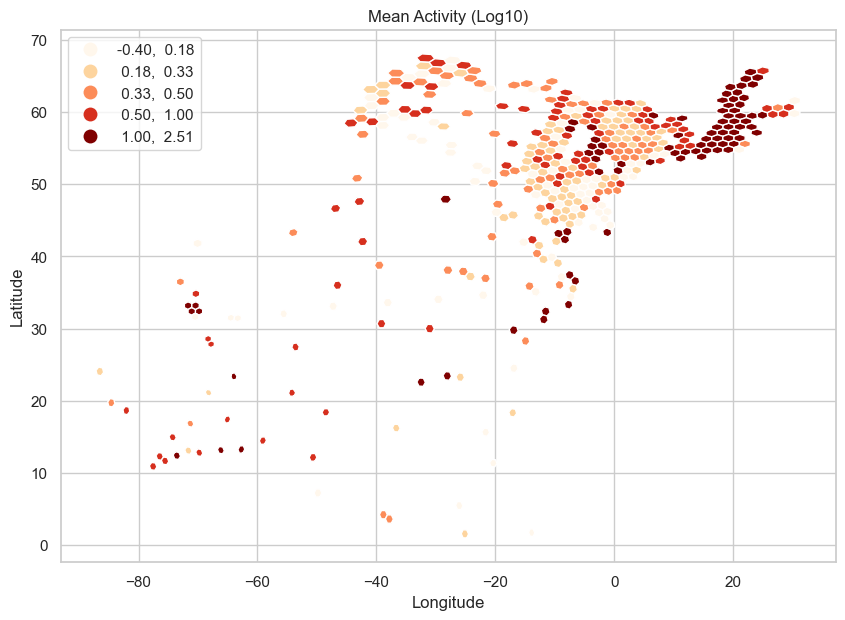

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, column='q2', cmap='OrRd', scheme='quantiles', 
         legend=True, legend_kwds={"loc": 2})

ax.set_title("Mean Activity (Log10)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude");

## Regionalization

### Spatial weights

#### Contiguity

In [ ]:
wq = weights.contiguity.Queen.from_dataframe(gdf)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 81 disconnected components.
 There are 63 islands with ids: 155, 182, 186, 213, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 290, 336, 338, 340, 344, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 359, 361, 378, 379, 380, 381, 382, 383, 384, 385, 386, 388, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 408, 409, 410, 411, 412, 413, 414, 415.
  warnings.warn(message)


In [ ]:
#wq.islands

#### K-nn

In [ ]:
wknn = weights.distance.KNN.from_dataframe(gdf, k=6)

#### Merge (where islands)

In [ ]:
def merge(wq, wknn):
    neighbors = wq.neighbors.copy()
    for i in wq.islands:
        neighbors[i] = list(wknn[i].keys())
    return weights.W(neighbors)

w = merge(wq, wknn)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


#### Get disconnected components

In [ ]:
idx_cpt = lambda i: np.where(w.component_labels == i)[0]
w_cpt = lambda i: w_subset(w, idx_cpt(i))

w_cpt(1).neighbors

{296: [297], 297: [296]}

## Clustering

In [ ]:
cpt = 0
max_clusters = 20
cols = ['q1', 'q2', 'q3', 'mean', 'min', 'max', 'std']


In [ ]:
X = gdf.iloc[idx_cpt(cpt)][cols].values; X.shape

(401, 7)

In [ ]:
X = gdf.iloc[idx_cpt(cpt)][cols].values
X_t = StandardScaler().fit_transform(X)

for n in range(2, max_clusters+1):
    model = AgglomerativeClustering(
        linkage='ward', 
        connectivity=w_cpt(cpt).sparse,
        n_clusters=n
    )
    model.fit(X_t)
    
    score = calinski_harabasz_score(X_t, model.labels_)
    print(f'# clusters: {n} | score: {score}')

# clusters: 2 | score: 205.68240575645135
# clusters: 3 | score: 186.48756654418966
# clusters: 4 | score: 156.6271842864183
# clusters: 5 | score: 137.12149096992192
# clusters: 6 | score: 122.6397105600404
# clusters: 7 | score: 112.53759816748021
# clusters: 8 | score: 105.32552351362959
# clusters: 9 | score: 100.56557967380338
# clusters: 10 | score: 95.53114818226196
# clusters: 11 | score: 90.36583648444461
# clusters: 12 | score: 86.03560586266352
# clusters: 13 | score: 81.14574371792072
# clusters: 14 | score: 78.23039071382037
# clusters: 15 | score: 75.89297890705187
# clusters: 16 | score: 73.9070614497664
# clusters: 17 | score: 72.33995196499008
# clusters: 18 | score: 71.12566302635588
# clusters: 19 | score: 70.18787602581307
# clusters: 20 | score: 69.33424618212173


In [ ]:
n_clusters = 5 
cpt = 0
X = gdf.iloc[idx_cpt(cpt)][cols].values
X_t = StandardScaler().fit_transform(X)

model = AgglomerativeClustering(
    linkage='ward', 
    connectivity=w_cpt(cpt).sparse,
    n_clusters=n_clusters
)

model.fit(X_t)

AgglomerativeClustering(connectivity=<401x401 sparse matrix of type '<class 'numpy.float64'>'
	with 1796 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

### Visualize

In [ ]:
gdf_sub = gdf.iloc[idx_cpt(cpt),:].copy()
gdf_sub['cluster'] = model.labels_

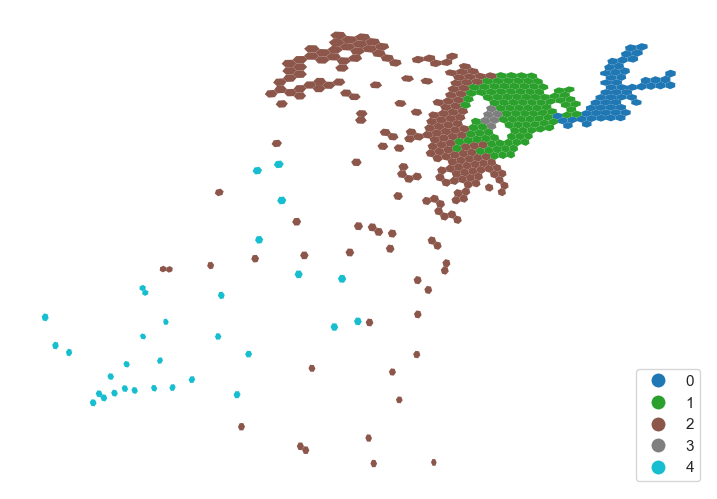

In [ ]:
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf_sub.plot(
    column="cluster",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
    legend_kwds={'loc': 'lower right'}
)

ax.set_axis_off()

In [ ]:
def style_function(feature, n_clusters, prop_name='cluster', palette=Tableau_10):
    attribute_value = feature['properties'][prop_name]
    return {'fillColor': palette.hex_colors[attribute_value], 
            'color': 'none', 
            'fillOpacity': 0.5}

In [ ]:
gdf = gdf_sub.to_crs(epsg=4326)

m = folium.Map(location=[gdf_sub.centroid.y.mean(), 
                         gdf_sub.centroid.x.mean()], zoom_start=3)

geojson_data = gdf_sub.to_json()

folium.GeoJson(geojson_data, style_function=partial(style_function, n_clusters=n_clusters)).add_to(m)

m

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_24047/914515011.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf_sub.centroid.y.mean(),
/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_24047/914515011.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_sub.centroid.x.mean()], zoom_start=3)


/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_24047/2958626089.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.histplot(data=gdf_sub, x='mean', hue='cluster',


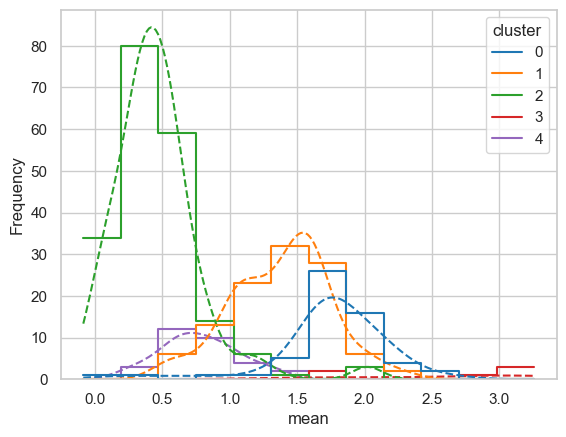

In [ ]:
sns.histplot(data=gdf_sub, x='mean', hue='cluster', 
             fill=False,
             multiple='layer', 
             element='step',
             palette=Tableau_10.mpl_colors,
             kde=True, 
            #  alpha=0.6,
             line_kws={'linestyle': 'dashed', 'alpha': 1}
             )

plt.xlabel('mean')
plt.ylabel('Frequency');

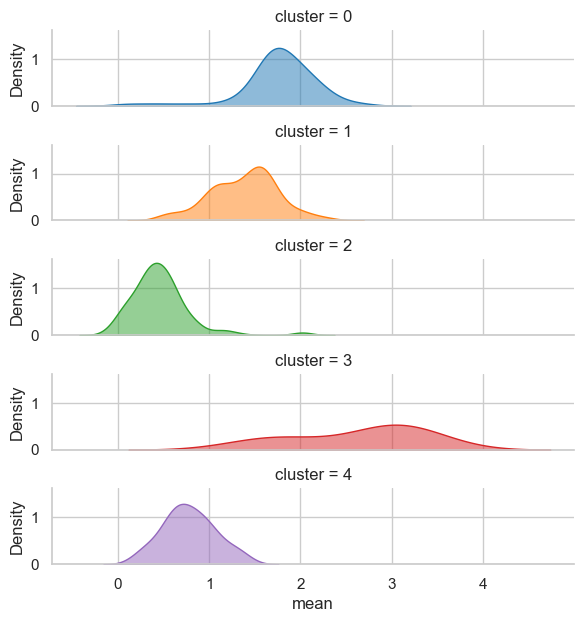

In [ ]:
sns.set(style="whitegrid")
g = sns.FacetGrid(gdf_sub, row='cluster', sharex=True, 
                  aspect=4, height=1.5,
                  palette=Tableau_10.mpl_colors, hue='cluster')

# g.map(sns.kdeplot, 'mean', color='blue', alpha=0.5, fill=True)
g.map(sns.kdeplot, 'mean', alpha=0.5, fill=True)

# Set plot labels and title
g.set_axis_labels('mean', 'Density')
g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('Faceted KDE Plot with Adjusted Alpha');

### Mergin hexs within same cluster

In [ ]:
gdf_sub.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n,geometry,cluster
0,83060cfffffffff,0.800548,0.803136,0.805724,0.896058,0.797960,0.962843,0.070861,3,"POLYGON ((-30.74454 67.97965, -32.32731 68.059...",2
1,83060dfffffffff,0.308863,0.310338,0.311812,0.381109,0.307389,0.454830,0.073720,2,"POLYGON ((-31.11303 66.88546, -32.62750 66.957...",2
2,830628fffffffff,-0.040653,-0.032400,-0.024148,0.235645,-0.048905,0.392116,0.201541,3,"POLYGON ((-26.14785 67.65771, -27.65321 67.778...",2
3,830629fffffffff,-0.022718,-0.020132,-0.009268,0.576696,-0.025304,1.042979,0.318900,39,"POLYGON ((-26.70519 66.58963, -28.15044 66.701...",2
4,83062bfffffffff,0.605093,0.610302,0.615512,0.782245,0.599883,0.886491,0.129390,3,"POLYGON ((-28.65447 67.29323, -30.16748 67.389...",2


<Axes: >

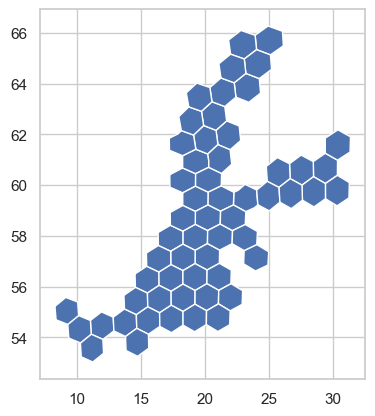

In [ ]:
gdf_sub[gdf_sub.cluster == 0].plot()

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_24047/3762525360.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geom = gdf_sub[gdf_sub.cluster == cluster].buffer(0.001).unary_union
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


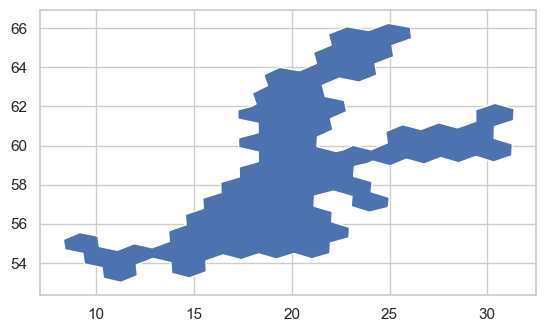

In [ ]:
cluster = 0
geom = gdf_sub[gdf_sub.cluster == cluster].buffer(0.001).unary_union
gdf_cluster_union = gpd.GeoDataFrame({'geometry': [geom]})
gdf_cluster_union.plot();